In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom, nbinom, lognorm, pareto, gamma
import scipy.stats as stats

In [23]:
# Load the claims data file into a DataFrame 
file_path = "/Users/thomasdeconinck/Documents/GitHub/Assurance-Code-Python/claim_data_group4_2024.csv"
claims_data = pd.read_csv(file_path)

In [24]:
claims_data

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0
2,72908,0,0.50,E,7,11,67,50,B3,Regular,4762,R93,0.0
3,2283027,0,0.08,B,5,8,28,60,B1,Diesel,64,R91,0.0
4,1123838,0,0.03,A,11,1,38,50,B2,Regular,16,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0
99996,4163362,0,0.22,E,6,13,58,50,B1,Diesel,4762,R93,0.0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0
99998,2012998,0,0.71,D,9,9,36,54,B1,Regular,1541,R91,0.0


In [25]:
# Filter out zero claim amounts for severity analysis
claim_counts = claims_data['ClaimNb']
non_zero_claims = claims_data[claims_data['ClaimAmount'] > 0]['ClaimAmount']

In [26]:
def calculate_aic(n, ll, k):
    """ Calculate Akaike Information Criterion. """
    return 2 * k - 2 * ll + 2 * k * (k + 1) / (n - k - 1)

def calculate_bic(n, ll, k):
    """ Calculate Bayesian Information Criterion. """
    return -2 * ll + k * np.log(n)

def plot_fit(x, dist, params, title, dist_type='continuous'):
    plt.figure(figsize=(10, 6))
    if dist_type == 'continuous':
        count, bins, ignored = plt.hist(x, bins=30, density=True, alpha=0.5, color='blue', label='Empirical Data')
        x_range = np.linspace(min(bins), max(bins), 100)
        probabilities = dist.pdf(x_range, *params) if dist != pareto else dist.pdf(x_range, *params, scale=1)
        plt.plot(x_range, probabilities, 'r-', linewidth=2, label=f'Fit: {dist.name}')
    else:
        weights = np.ones_like(x) / len(x)
        count, bins, ignored = plt.hist(x, bins=np.arange(x.min(), x.max() + 2) - 0.5, weights=weights, alpha=0.5, color='blue', label='Empirical Data')
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        probabilities = dist.pmf(bin_centers, *params) if dist != pareto else dist.pmf(bin_centers, *params, scale=1)
        plt.plot(bin_centers, probabilities, 'r-', linewidth=2, label=f'Fit: {dist.name}')

    plt.title(title)
    plt.xlabel('Number of Claims' if dist_type == 'discrete' else 'Claim Amount')
    plt.ylabel('Probability' if dist_type == 'discrete' else 'Density')
    plt.legend()
    plt.show()

    # Safe log-likelihood calculation
    eps = 1e-10  # A small constant to prevent log(0)
    log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps)) if dist_type == 'discrete' else np.sum(np.log(dist.pdf(x, *params) + eps))
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

# Fitting Claim Frequency Distributions

## Fitting with Poisson, Binomial and Negative Binomial Distribution
We fit the claim frequency data to three different distributions: Poisson, Binomial, and Negative Binomial. For each distribution, the parameters are estimated using the respective fitting methods. The fitted parameters are then used to plot the frequency distribution.

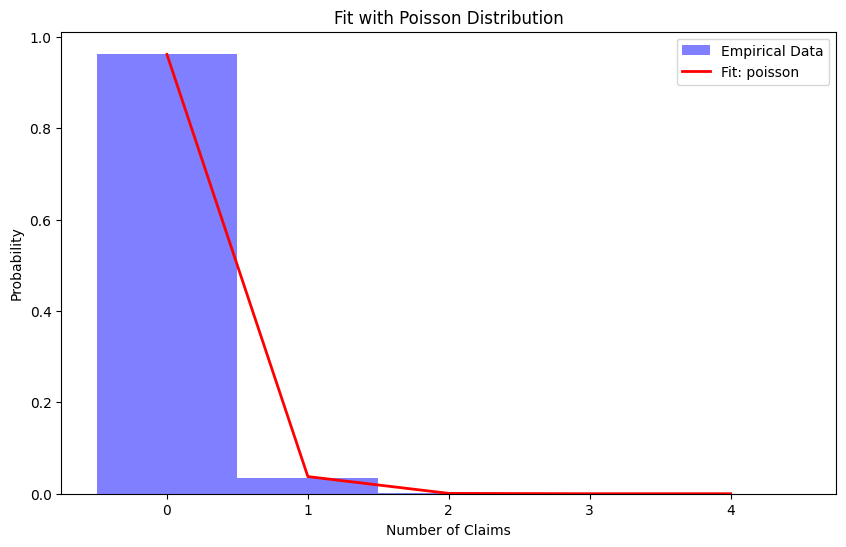

AIC for Fit with Poisson Distribution: 33460.499374859624
BIC for Fit with Poisson Distribution: 33470.0122603238


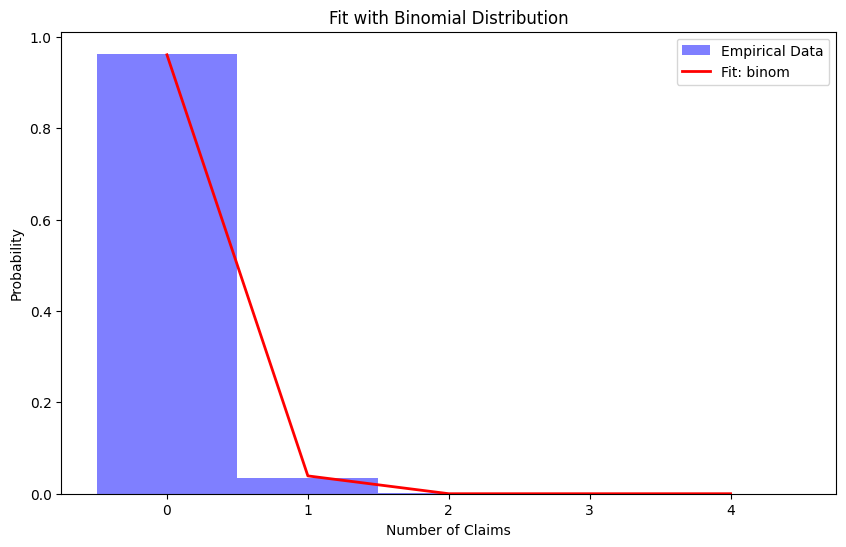

AIC for Fit with Binomial Distribution: 40311.18360245922
BIC for Fit with Binomial Distribution: 40330.20933338556


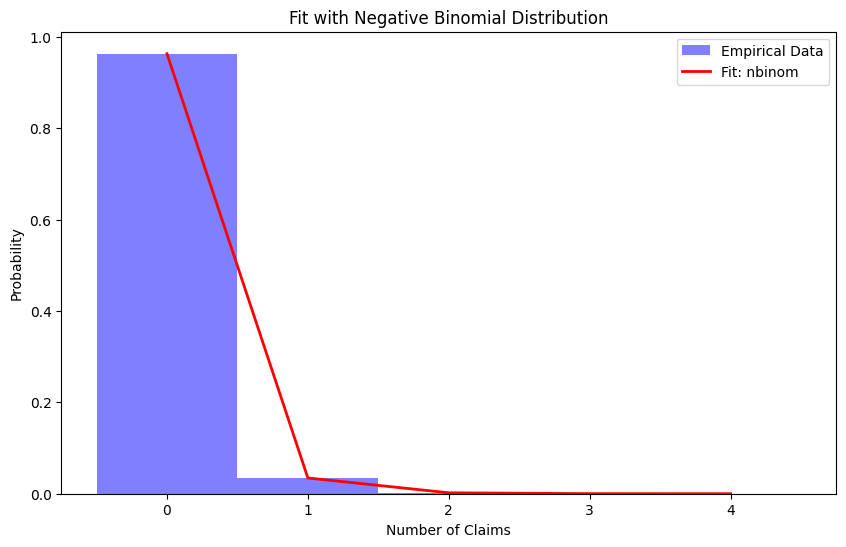

AIC for Fit with Negative Binomial Distribution: 33220.908366396994
BIC for Fit with Negative Binomial Distribution: 33239.934097323334


In [27]:
# Poisson Distribution Fitting
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
plot_fit(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials = 1  # This should be adjusted based on your specific scenario
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
plot_fit(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin = (np.mean(claim_counts)**2) / (np.var(claim_counts) - np.mean(claim_counts))
p_negbin = r_negbin / (r_negbin + np.mean(claim_counts))
params_negbin = [r_negbin, p_negbin]
plot_fit(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')

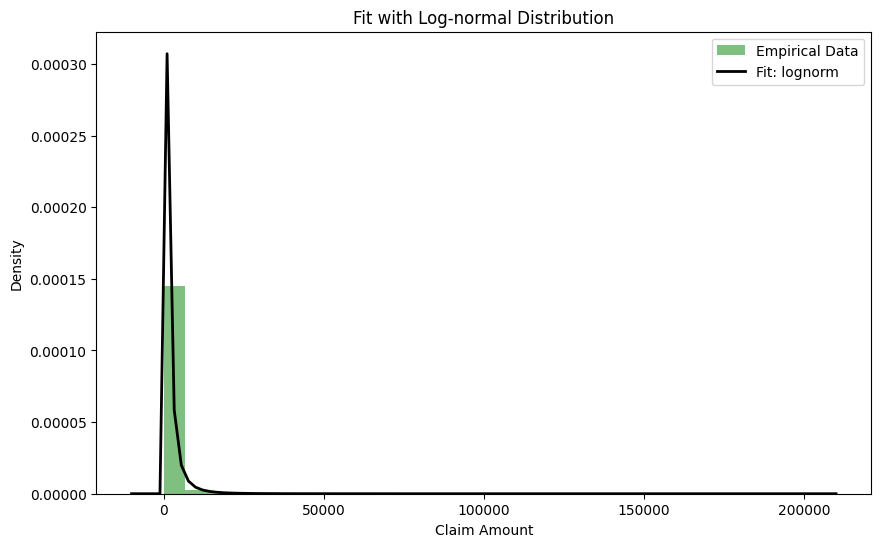

AIC for Fit with Log-normal Distribution: 61901.186253035194
BIC for Fit with Log-normal Distribution: 61919.79944829225


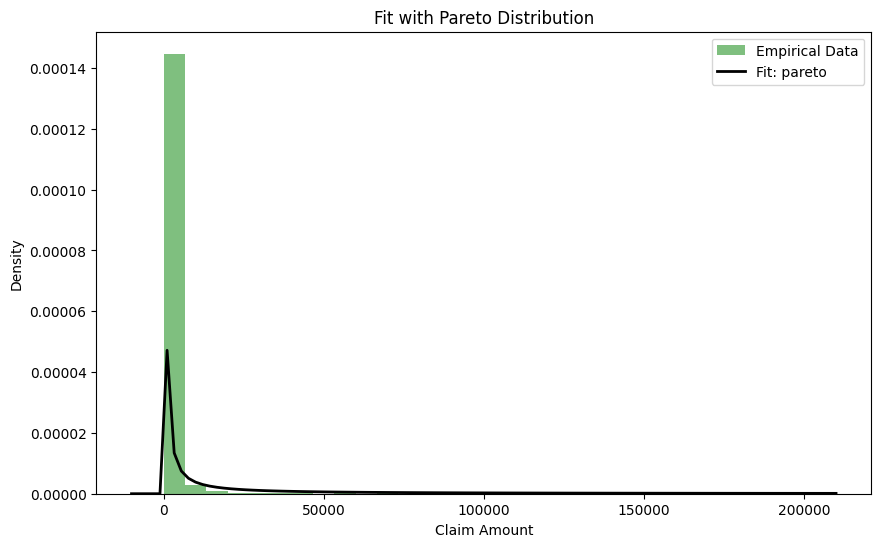

AIC for Fit with Pareto Distribution: 71878.08174119866
BIC for Fit with Pareto Distribution: 71896.69493645572


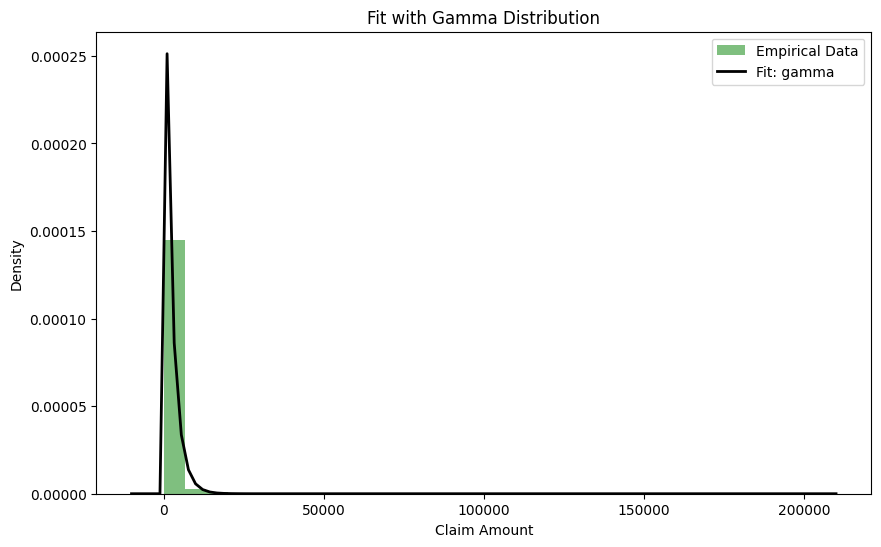

AIC for Fit with Gamma Distribution: 63202.40850800119
BIC for Fit with Gamma Distribution: 63221.021703258244


In [28]:
def calculate_aic(n, ll, k):
    """
    Calculate Akaike Information Criterion.
    """
    return 2*k - 2*ll + 2*k*(k+1)/(n-k-1)

def calculate_bic(n, ll, k):
    """
    Calculate Bayesian Information Criterion.
    """
    return -2*ll + k*np.log(n)

def plot_fit_severity(x, dist, params, title):
    plt.figure(figsize=(10, 6))
    count, bins, ignored = plt.hist(x, bins=30, density=True, alpha=0.5, color='g', label='Empirical Data')
    xmin, xmax = plt.xlim()
    x_range = np.linspace(xmin, xmax, 100)

    if dist != pareto:
        probabilities = dist.pdf(x_range, *params)
        log_likelihood = np.sum(np.log(dist.pdf(x, *params)))
    else:
        probabilities = dist.pdf(x_range, *params)
        log_likelihood = np.sum(np.log(dist.pdf(x, *params)))

    plt.plot(x_range, probabilities, 'k-', linewidth=2, label=f'Fit: {dist.name}')
    plt.title(title)
    plt.xlabel('Claim Amount')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Calculate AIC and BIC
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

# Fitting Claim Severity Distributions

## Fitting with Log-normal Distribution, Pareto and Gamma
We fit the claim severity data to a log-normal, Pareto and Gamma distribution. The parameters of the distribution are estimated using the `lognorm.fit` method with `floc` set to 0. 
The fitted parameters are then used to plot the severity distribution

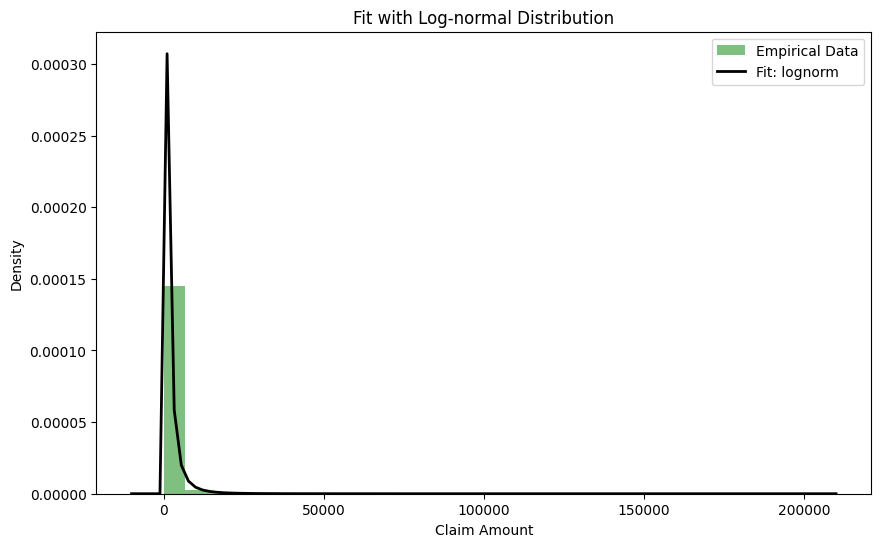

AIC for Fit with Log-normal Distribution: 61901.186253035194
BIC for Fit with Log-normal Distribution: 61919.79944829225


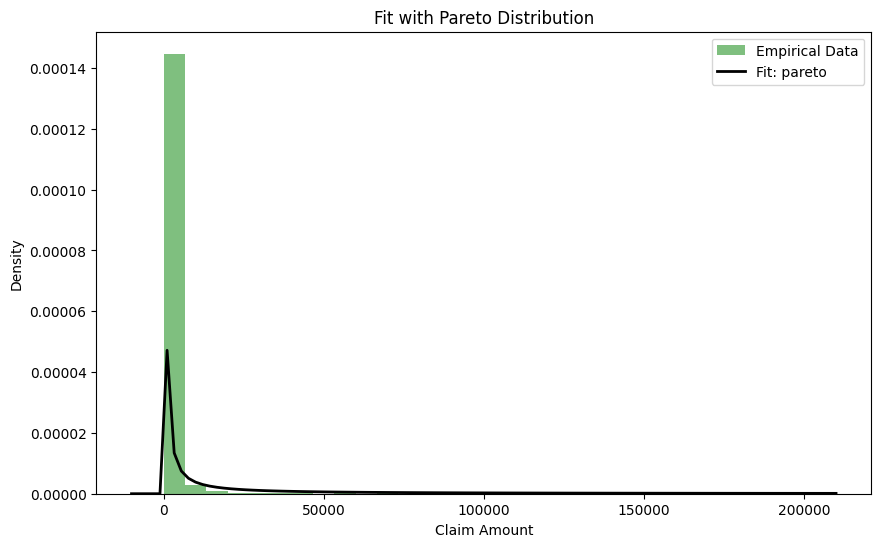

AIC for Fit with Pareto Distribution: 71878.08174119866
BIC for Fit with Pareto Distribution: 71896.69493645572


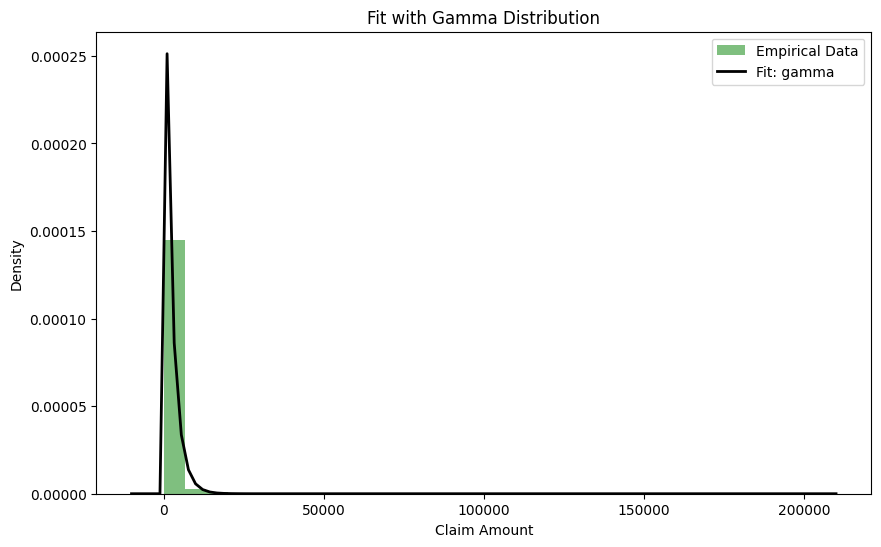

AIC for Fit with Gamma Distribution: 63202.40850800119
BIC for Fit with Gamma Distribution: 63221.021703258244


In [29]:
# Log-normal fitting
shape, loc, scale = lognorm.fit(non_zero_claims, floc=0)
params_lognorm = [shape, loc, scale]
plot_fit_severity(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution')

# Pareto fitting
b, loc, scale = pareto.fit(non_zero_claims, floc=0)  # Fitting with floc set to 0
params_pareto = [b, loc, scale]
plot_fit_severity(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution')

# Gamma fitting
alpha, loc, beta = gamma.fit(non_zero_claims, floc=0)  # Adjusting fit parameters as needed
params_gamma = [alpha, loc, beta]
plot_fit_severity(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution')

In [15]:
# Get descriptive statistics from the claims data set 
descriptive_stats = claims_data.describe()
descriptive_stats

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Frequency
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,2.617735e+06,0.039020,0.528057,6.460230,6.992550,45.483040,59.822980,1800.69569,76.599887,0.119194
std,1.643394e+06,0.206296,0.364232,2.055641,5.637297,14.154698,15.652541,3955.08311,1531.841302,2.141210
min,1.500000e+01,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,2.00000,0.000000,0.000000
25%,1.156127e+06,0.000000,0.170000,5.000000,2.000000,34.000000,50.000000,94.00000,0.000000,0.000000
50%,2.271008e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,399.00000,0.000000,0.000000
75%,4.044791e+06,0.000000,0.990000,7.000000,11.000000,55.000000,65.000000,1658.00000,0.000000,0.000000
max,6.114324e+06,4.000000,1.000000,15.000000,100.000000,99.000000,230.000000,27000.00000,200000.000000,365.000004


In [16]:
# Get the distribution of individual claims
claims_distribution = claims_data['ClaimNb'].value_counts()
claims_distribution

ClaimNb
0    96335
1     3441
2      214
3        7
4        3
Name: count, dtype: int64

In [17]:
# Total claims by driver's age 
total_claims_by_age = claims_data.groupby('DrivAge')['ClaimNb'].sum()
total_claims_by_age = pd.DataFrame(total_claims_by_age)
total_claims_by_age

,ClaimNb
DrivAge,
18,6
19,30
20,55
21,42
22,58
...,...
94,0
95,1
96,0


In [18]:
# Total claims by driver's age 
total_claims_by_age = claims_data.groupby('VehAge')['ClaimNb'].sum()
total_claims_by_vech_age = pd.DataFrame(total_claims_by_age)
print(total_claims_by_vech_age.head)

<bound method NDFrame.head of         ClaimNb
VehAge         
0           167
1           326
2           335
3           288
4           267
5           227
6           219
7           240
8           227
9           254
10          248
11          208
12          187
13          154
14          161
15          136
16           83
17           73
18           38
19           19
20           16
21            8
22            8
23            4
24            2
25            0
26            3
27            0
28            2
29            1
30            1
31            0
32            0
33            0
34            0
35            0
36            0
37            0
38            0
39            0
40            0
41            0
43            0
44            0
45            0
46            0
47            0
50            0
52            0
65            0
66            0
68            0
99            0
100           0>


In [19]:
# Total claims by Bonus/Malus 
total_claims_by_bonus_malus = claims_data.groupby('BonusMalus')['ClaimNb'].sum()
total_claims_by_bonus_malus = pd.DataFrame(total_claims_by_bonus_malus)
total_claims_by_bonus_malus

,ClaimNb
BonusMalus,
50,1694
51,59
52,28
53,18
54,63
...,...
190,0
195,0
196,0


In [20]:
# Total claims by driver's age 
total_claims_by_age = claims_data.groupby('VehPower')['ClaimNb'].sum()
total_claims_by_vech_power = pd.DataFrame(total_claims_by_age)
total_claims_by_vech_power

,ClaimNb
VehPower,
4,529
5,764
6,929
7,849
8,257
9,194
10,157
11,112
12,57


In [21]:
# Plotting the distribution of ClaimNb
plt.figure(figsize=(8, 6))
sns.countplot(x='ClaimNb', data=claims_data, palette='Set2')
plt.title('Distribution of Number of Claims')
plt.xlabel('Number of Claims')
plt.ylabel('Frequency')
plt.show()

NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

In [67]:
skewness = skew(claims_data['ClaimNb'])
kurt = kurtosis(claims_data['ClaimNb'])
skewness, kurt

(np.float64(5.729207125692899), np.float64(37.72487026616426))